In [5]:
import pandas as pd
import xlrd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import math

In [44]:
###Citanje tabela sa PIS sajta
### Tabele su prethodno prebacene u xls format
###
#*Vadjenje pouzdanih periods
#*Nalazenje i zabalezavanje rupa u temperaturama i u datumima (satima)


folder_podataka = "./PISpodaci"
folder_rezultata = "./results"
pregled = pd.read_excel("./samoPouzdaniPodaciTabela.xlsx", converters= {'kraj': pd.to_datetime, 'pocetak': pd.to_datetime})
preslikavanje_opstina = {"Novi Sad": "NS", "Ruma":"RU","Sombor":"SO","Zrenjanin":"ZR","Kikinda":"KI"}
preslikavanje_lokacija = {"Cenej": "CE" ,"Novi Slankamen":"NS","Ridjica":"RI","Sremski Karlovci":"SK","Sutjeska":"SU","Kikinda":"KI","Nestin":"NE"}
z=None
#za svaku PIS tabelu, cemo napraviti korespondirajucu PIS tabelu, sa pouzdanim podacima + vrsta i mesto
# VAZNO !! Moraju biti prebaceni u xls format posle skidanja sa PIS sajta. To se moze uraditi otvaranjem u Excelu i cuvsanju u xls formatu
for fname in os.listdir(folder_podataka):
    print (fname)
    #IZVLACENJE AMS naziva iz imena fajla !
    ams =fname.split('_')[0] ## REFACTOR - ovo mora da bude regex. 
    print(ams)
    assert(re.match("0+[0-9A-F]+",ams)) # REFACTOR - napravi bolji regex, more robust
    #IZVLACENJE PODATAKA IZ PREGLED TABELE
    record_for_ams = pregled[pregled.ams==ams] #za ovu ams samo trzimo records
    #ako nije oznacen kraj - popunimo ga sa trenutnim datumom, posto to znaci da je jos uvek tamo
    record_for_ams.kraj = record_for_ams.kraj.fillna(pd.Timestamp.today())#REFACTOR TODO!! - popuni ih sa poslednjom skinutom vrednoscu za taj AMS (to je preciznije)
    #UCITAVANJE TABELE
    PIStabela=pd.read_excel(os.path.join(folder_podataka,fname),header=[0,1])
    PIStabela = PIStabela.sort_index()
    #flattening the header
    #SREDJIVANJE TABELE!!
    PIStabela.columns = [' '.join(col).strip() for col in PIStabela.columns.values]
    #samo uzimamo temperature, tj prve tri kolone, za ovu svrhu 
    PIStabela = PIStabela.iloc[:,0:3]
    assert("Temperature" in col for col in PIStabela.columns)
#z = pd.concat(z.values(),axis=0)
    assert(len(PIStabela.columns)==3)
    #prvo cemo ih iseci po periodima, i onda cemo ih spojiti u jednu tabelu !!
    tabele_za_jedan_ams = []
    #pravimo i tabele sa nedostajucim vrednostima
    missing_periods_za_jedan_ams = []
    missing_data_za_ams = []
    #idemo kroz PREGLED tabelu i za svaku stavku odvojim deo PIS tabele, koja je pouzdana
    for index,row in record_for_ams.iterrows():
        assert(row.pocetak< row.kraj)
        print (row.pocetak,row.kraj)
        #izuzimamo dan postavljanja, posto ne znamo kad je postavljenja
        izuzet_dan_postavljanja = (row.pocetak+pd.offsets.DateOffset(days=1)) 
        #uzimamo samo deo za koji znamo da je pouzdan (tj. bio na lokaciji bez pomeranja)
        novi = PIStabela.loc[izuzet_dan_postavljanja:row.kraj].copy() 
        #popunjavamo ostale podatke, posto znamo da su bili sigurno na jednoj lokaciji u jednoj sorti za taj period
        novi["opstina"] = row.opstina #popunjavamo podatke, koje sad znamo za sigurno
        novi["mesto"] = row.mesto
        novi["usev"] = row.usev
        tabele_za_jedan_ams.append(novi) #jos uvek smo kod istog AMS-a, i sve sto nadjemo cemo nakaciti
        missing_temperatures = novi[novi.isnull().any(axis=1)] # kolone koje imaju nedostajuce vrednosti, tj. temperature u ovom slucaju
        #cuvamo ovaj deo podataka (mozda je suvisno !)
        novi.to_csv(os.path.join(folder_rezultata,"%s_%s_%s_%s_%s.csv"%(ams,preslikavanje_opstina[row.opstina],preslikavanje_lokacija[row.mesto],row.usev,row.pocetak)))    
        #Trazimo nedostajuce datume 
        idx_ref = pd.DatetimeIndex(start=novi.index[0], end=novi.index[-1], freq="h")
        gaps = idx_ref[~idx_ref.isin(novi.index)]
        missing = pd.DataFrame(index=gaps)
        missing["opstina"]= row.opstina
        missing["mesto"] = row.mesto
        missing["usev"] = row.usev
        #zapisujemo nedostajuce datume za jedan period - mozda suvisno !
        missing.to_csv(os.path.join(folder_rezultata,"missing_periods_%s_%s" %(ams+row.opstina+row.mesto +row.usev,row.pocetak)))
        #sve missinge sa odredjen ams cuvamo u jednoj tabeli - mozemo ih kasnije po lokaciji ako treba
        missing_periods_za_jedan_ams.append(missing)
        missing_data_za_ams.append(missing_temperatures)
    frejmovi_za_ams = pd.concat(tabele_za_jedan_ams)
    
    #svi valjani podaci za jedan ams
    frejmovi_za_ams.to_csv(os.path.join(folder_rezultata,"%s_pouzdaniPeriodi_biljneVrste_lokacije.csv" %(ams)))
    missing_periods = pd.concat(missing_periods_za_jedan_ams)
    missing_periods.to_csv(os.path.join(folder_rezultata,"%s_missing_periods.csv" %ams))
    missing_data = pd.concat(missing_data_za_ams)
    missing_data.to_csv(os.path.join(folder_rezultata,"%s_missing_data.csv" %ams))

00000EA5_station_data.xlsx
00000EA5
2010-04-20 00:00:00 2013-03-29 00:00:00
2013-03-29 00:00:00 2019-01-29 13:18:05.566018
00000DAD_station_data.xlsx
00000DAD
2012-12-03 00:00:00 2019-01-29 13:18:14.571860
00000E94_station_data.xlsx
00000E94
2010-04-16 00:00:00 2019-01-29 13:18:15.779603
00000E8C_station_data.xlsx
00000E8C
2012-01-10 00:00:00 2019-01-29 13:18:24.155877
00000EA1_station_data.xls
00000EA1
2011-07-12 00:00:00 2019-01-29 13:18:24.931308
00000E9A_station_data.xls
00000E9A
2013-08-02 00:00:00 2018-11-19 00:00:00


In [7]:

def izracunaj_CHU(podaci):

    zbir = 0
    end_of_chilling_index = None
    end_of_chilling_date = None
    chilling_units_max = 1800
    for index, row in podaci.iterrows(): 
        if row.Tavg <= 1.4:
            zbir+=0
        elif row.Tavg <=2.4:
            zbir+=0.5
        elif row.Tavg <= 9.1:
            zbir+=1
        elif row.Tavg <=12.4:
            zbir+=0.5
        elif row.Tavg <=15.9:
            zbir+=0
        elif row.Tavg <=18.0:
            zbir+=-0.5
        else:
            zbir+=-1
    return zbir
        
def izracunaj_HU(podaci):
    
    Tu = 25 # optimum temperature
    Tc = 36 # critical temperature
    Tb = 4 #base temperature
    F = 1 # plant stress factor, 1 where no particular stress
    GDH = 0
    for i, row in podaci.iterrows():
        if (row.Tavg >=Tb) and (row.Tavg < Tu):
            z =  F*((Tu-Tb)/2)*(1+ math.cos(math.pi + math.pi*((row.Tavg -Tb)/(Tu-Tb))))
            GDH+=z  
        elif (row.Tavg >=Tu) and (row.Tavg<=Tc):
            z= F*(Tu-Tb)*(1+ math.cos(math.pi/2 + (math.pi/2)*((row.Tavg -Tu)/(Tc-Tu))))
            GDH+=z
        else:
            GDH+=0
            
    return GDH

In [46]:
mesta = ["RU_IK","SM_MA","ZR_SU","NS_CE","RU_NS"]
mesta = ["NS_CE","ZR_SU","KI_KI","NS_NE"]
sorte = ["ZD","AJ"]

rezultat = pd.DataFrame(columns = ["sorta","lokalitet","CHU","HU","chilling start","dormancy end","dormancy end BBCH","flowering start","flowering start BBCH"])

#za sve podatke koje imamo popunjene/pouzdane
#cemo citati ove podatke fenologije

folder_fenologija = "./fenologija"
folder_podataka = "./results/popunjenirezultati"

for fname_podaci in os.listdir(folder_podataka): # za svaki set podataka
    lokalitet = fname_podaci[:5] #NS_CE npr
    assert (lokalitet in mesta) #provera 
    print ("lokalitet: %s" %lokalitet)
     #ucitavamo podatke
    podaci = pd.read_csv(os.path.join(folder_podataka,fname_podaci),index_col=0)
    #stavljamo da index bude datum, vazno je da je dayfirst=True, posto su tako sacuvani izgleda
    podaci.index = pd.to_datetime(podaci.index,dayfirst=True)
    
    #uzimamo sve podatke fenologije za odabrani lokalitet (tj. onaj koji je na redu)
    gen = (fname for fname in os.listdir(folder_fenologija) if (lokalitet in fname) and ("~" not in fname))
    #za svaku fenolosku tabelu za odabran lokalitet
    for fname_fenologija in gen:
        #uzimamo godinu i sortu iz naziva fajla 
        year = int(fname_fenologija.split("_")[3].split(".")[0])
        sorta = fname_fenologija.split("_")[-2]
        print ("sorta: %s" %sorta)
        #pocinjemo racunanje od Novembra prosle godine
        chilling_start = pd.Timestamp(year=year-1, month=11, day=1, hour=0)
        print (fname_fenologija)
        #ucitavanje i sredjivanje tabele (sortiranje po datumima)
        fenologija = pd.read_excel(os.path.join(folder_fenologija,fname_fenologija))
        fenologija.Date = pd.to_datetime(fenologija.Date,yearfirst=True)
        fenologija = fenologija.set_index(fenologija.Date).drop("Date",1).sort_index()
        #kraj dormancije je prvi red u tabeli za koji je BBCH>=1
        dormancy_end = fenologija[fenologija.BBCH>=1].iloc[0]
        #cvetanje je prvi red u tabeli za koje je BBCH>=60
        cvetanje = fenologija[fenologija.BBCH>=60].iloc[0]

        dormancy_end_date = dormancy_end.name
        cvetanje_start_date = cvetanje.name
        print("chilling start: %s chilling end: %s" %(chilling_start,dormancy_end_date))
        # podaci za racunanje CHU-a, od pocetka novembra do kraja dormancije
        chilling_period_podaci = podaci.loc[chilling_start:dormancy_end_date]
        CHU = izracunaj_CHU(chilling_period_podaci)
        print ("CHU: %s" %CHU)
        #podaci za racunanje HU-a, od kraja dormancije do pocetka cvetanja
        cvetanje_podaci = podaci.loc[dormancy_end_date:cvetanje_start_date]
        HU =izracunaj_HU(cvetanje_podaci)
        print ("HU: %s" %HU)
        #sve stavljamo u jednu veliku tabelu iz koje cemo kasnije izvlaciiti lokalitet i sorte
        rezultat = rezultat.append({"sorta":sorta,"lokalitet":lokalitet,"CHU":int(CHU),"HU":int(HU),"chilling start":chilling_start,"dormancy end": dormancy_end_date,"dormancy end BBCH":dormancy_end.BBCH,"flowering start":cvetanje_start_date,"flowering start BBCH": cvetanje.BBCH},ignore_index=True)
        
        
print (rezultat)
for sorta in sorte:
    podaci_za_sortu = rezultat[rezultat.sorta==sorta]
    podaci_za_sortu.to_csv("CHU_HU_%s.csv" %sorta)
    


        


lokalitet: NS_NE
sorta: AJ
NS_NE_AJ_2018.xlsx
chilling start: 2017-11-01 00:00:00 chilling end: 2018-02-09 00:00:00
CHU: 1378.5
HU: 5233.8283258522215
lokalitet: KI_KI
sorta: ZD
KI_KI_ZD_2018.xlsx
chilling start: 2017-11-01 00:00:00 chilling end: 2018-02-13 00:00:00
CHU: 1416.0
HU: 6119.874751724753
sorta: ZD
KI_KI_ZD_2017.xlsx
chilling start: 2016-11-01 00:00:00 chilling end: 2017-03-07 00:00:00
CHU: 1003.5
HU: 5050.467186169737
lokalitet: NS_CE
sorta: ZD
NS_CE_ZD_2018.xlsx
chilling start: 2017-11-01 00:00:00 chilling end: 2018-02-06 00:00:00
CHU: 1320.5
HU: 6566.825783430308
sorta: AJ
NS_CE_AJ_2017.xlsx
chilling start: 2016-11-01 00:00:00 chilling end: 2017-02-28 00:00:00
CHU: 914.5
HU: 5241.589087538984
sorta: ZD
NS_CE_ZD_2017.xlsx
chilling start: 2016-11-01 00:00:00 chilling end: 2017-03-08 00:00:00
CHU: 1005.0
HU: 4248.7373879070565
sorta: ZD
NS_CE_ZD_2014.xlsx
chilling start: 2013-11-01 00:00:00 chilling end: 2014-03-04 00:00:00
CHU: 1396.5
HU: 3899.0492094847177
sorta: AJ
NS_CE_

([array([1., 0., 0.]),
  array([0., 1., 0.]),
  array([0., 1., 0.]),
  array([1., 0., 0.]),
  array([0., 0., 1.]),
  array([0., 1., 0.]),
  array([1., 0., 0.]),
  array([0., 0., 1.])],
 array([ 848.        , 1103.33333333, 1358.66666667, 1614.        ]),
 <a list of 8 Lists of Patches objects>)

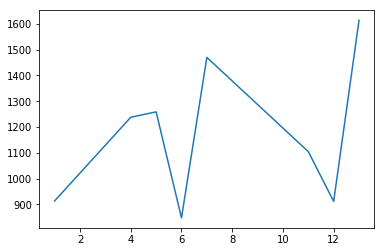

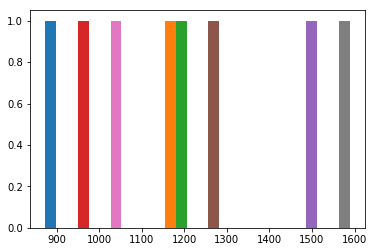

In [39]:
plt.plot(rezultat[rezultat.sorta=="AJ"]["CHU"])
ax= plt.figure()
ax.add_subplot()
plt.hist(rezultat[rezultat.sorta=="AJ"]["CHU"],bins=3)



In [32]:
ax.add_subplot?